# Tiền xử lý dữ liệu, xây dựng Loader

In [270]:
import torch 

import os
import re
import numpy as np
import pandas as pd

## **Phần xác định các cụm viết tắt**

In [271]:
CONTRACTIONS = {
    "aren't": "are not",
    "can't": "can not",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "she's":"she is",
    "she'll": "she will",
    "she'd": "she would",
    "i'd": "I would",
    "i'll": "I will",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "there're": "there are",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we'll":"we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "where's": "where is",
    "why's": "why is",
    "what've": "what have",
    "where's": "where is",
    "who'd": "who would",
    "who'll": "who will",
    "who're": "who are",
    "who's": "who is",
    "who've": "who have",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
    "wasn't":"was not",
    "it'll":"it will",
    "tom's":"tom is", 
    "one's":"one is",
    "somebody's": "sombody is",
    "someone's": "someone is",
    "that's": "that is",
    "how's": "how is",
    "should've": "should have",
    "why're": "why are",
    "might've": "might have",
    "o'clock": "of the clock",
    "here's": 'here is',
    "could've": "could have",
    "must've": "must have",
    "would've": "would have",
    "that'll": "that will"
}

## **Hàm chuẩn hóa các dấu câu, viết tắt, viết hoa**

**Thực hiện kèm Tokenizer bằng torchtext**

*Chuẩn hóa tiếng Anh*

In [272]:
file_path = r"E:\Đồ án 2\vie-eng\vie.txt"

def expand_match(contraction, contractions_dict= CONTRACTIONS):
    match = contraction.group(0)
    first_char = match[0]
    expanded = contractions_dict.get(match.lower())
    if expanded:
        if first_char.isupper():
            expanded = expanded[0].upper() + expanded[1:]
        return expanded
    return match

def replace_time(match):
        hours = match.group('hours')
        minutes = match.group('minutes')
        
        components = []
        
        if hours:
            hours = int(hours)
            hour_word = "hour" if hours == 1 else "hours"
            components.append(f"{hours} {hour_word}")
        
        if minutes:
            minutes = int(minutes)
            # Chuẩn hóa số phút
            if minutes < 10 and ':' in match.group():
                minutes = minutes * 10
            minute_word = "minute" if minutes == 1 else "minutes"
            components.append(f"{minutes} {minute_word}")
        
        return " ".join(components)

def text_normalize(file_path, contractions_dict= CONTRACTIONS):
    src_data = pd.read_csv(file_path, delimiter="\t", header= None)
    src_data.columns = ['src', 'tgt', 'ref']
    src_data = src_data.drop(columns=['ref'])

    normal_data = {}
    normal_data['src'] = []
    for row in src_data['src']:
    #Xóa dấu . cuối câu
        sentence = re.sub(r'\.$', '', row.strip())
        #Xóa khoảng trắng thừa
        sentence = re.sub(r'\s*,\s*', ', ', sentence)
        #Xóa dấu phẩy thừa
        sentence = re.sub(r',+', ',', sentence)
        #Tách dấu câu còn lại để lấy ngữ cảnh
        sentence = re.sub(r'([.!?])', r' \1', sentence)

        # Thực hiện thay thế viết tắt trong text
        pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b', re.IGNORECASE)    
        sentence = pattern.sub(expand_match, sentence)
        
        patterns = [
        # h:m hoặc h:mm
        r'(?P<hours>\d{1,2}):(?P<minutes>\d{1,2})',
        # Các định dạng khác
        r'(?P<hours>\d+)\s*h(?:\s*(?P<minutes>\d+)\s*m)?'
        ]
        for part in patterns:
            sentence = re.sub(part, replace_time, sentence, flags=re.IGNORECASE)
        #Xóa dấu " thừa ra
        sentence = re.sub(r"'", '', sentence)
        sentence = sentence.strip(r'"')
        sentence = sentence.strip(r"'")

        #sentence = tokenizer(sentence)
        normal_data['src'].append(sentence)
    
    normal_data['tgt'] = []
    for row in src_data['tgt']:
    #Xóa dấu . cuối câu
        sentence = re.sub(r'\.$', '', row.strip())
        #Xóa khoảng trắng thừa
        sentence = re.sub(r'\s*,\s*', ', ', sentence)
        #Xóa dấu phẩy thừa
        sentence = re.sub(r',+', ',', sentence)
        #Tách dấu câu còn lại để lấy ngữ cảnh
        sentence = re.sub(r'([.!?])', r' \1', sentence)
        # Thực hiện thay thế trong text
        pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b', re.IGNORECASE)    
        sentence = pattern.sub(expand_match, sentence)
        
        patterns = [
        # h:m hoặc h:mm
        r'(?P<hours>\d{1,2}):(?P<minutes>\d{1,2})',
        
        # Các định dạng khác
        r'(?P<hours>\d+)\s*h(?:\s*(?P<minutes>\d+)\s*m)?',
        ]
        for part in patterns:
            sentence = re.sub(part, replace_time, sentence, flags=re.IGNORECASE)
        #Xóa dấu " thừa ra
        sentence = re.sub(r"'", '', sentence)
        sentence = sentence.strip(r'"')
        sentence = sentence.strip(r"'")
        #sentence = tokenizer(sentence)
        normal_data['tgt'].append(sentence)

    
    return normal_data

normalized_data = text_normalize(file_path)


## **Thực hiện tạo vocab để vectorize các câu đầu vào En**

In [273]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
src_tokenizer = get_tokenizer("basic_english")
tgt_tokenizer = get_tokenizer("basic_english")

*Xử lý tạo vocab*

In [274]:
def yield_src_tokens(dataset):
    for row in dataset:
        yield src_tokenizer(row)

def yield_tgt_tokens(dataset):
    for row in dataset:
        yield tgt_tokenizer(row)

def buildVocab(yield_src_tokens, yeild_tgt_tokens):
    src_vocab = build_vocab_from_iterator(
        yield_src_tokens(normalized_data['src']), 
        specials=['<unk>', '<pad>', '<sos>', '<eos>'], 
        max_tokens= 1000, 
        min_freq= 2)
    src_vocab.set_default_index(src_vocab['<unk>'])

    tgt_vocab = build_vocab_from_iterator(
        yield_tgt_tokens(normalized_data['tgt']),
        specials=['<unk>', '<pad>', '<sos>', '<eos>'],
        max_tokens= 1000, 
        min_freq= 2)
    tgt_vocab.set_default_index(tgt_vocab['<unk>'])

    return src_vocab, tgt_vocab

src_vocab, tgt_vocab = buildVocab(yield_src_tokens, yield_tgt_tokens)

**Token to index**, **Index to token**

In [275]:
src_token_to_idx = {token : idx for token, idx in enumerate(src_vocab.get_itos())}
src_idx_to_token = {idx : token for token, idx in enumerate(src_vocab.get_itos())}

tgt_token_to_idx = {token : idx for token, idx in enumerate(tgt_vocab.get_itos())}
tgt_idx_to_token = {idx : token for token, idx in enumerate(tgt_vocab.get_itos())}

## **Số hóa các vector đầu vào**

In [276]:
from torch.utils.data import DataLoader, Dataset
from torchtext import transforms as T

*Hàm tạo các chuyển đổi cho câu*

In [277]:
def getTransform(vocab):
    """
    Create the transform functions for the senquence.
    """
    text_transform = T.Sequential(
        T.VocabTransform(vocab),
        T.AddToken(2, True),
        T.AddToken(3, False)
    )
    return text_transform


*Số hóa sequence*

In [278]:
def tokenize_dataset(normalized_data):
    tokenized_data = {}
    for column in normalized_data:
        tokenized_data[column] = []
        if column== 'src':
            for row in normalized_data[column]:
                tokenized_data[column].append(src_tokenizer(row))
        if column== 'tgt':
            for row in normalized_data[column]:
                tokenized_data[column].append(tgt_tokenizer(row))


    return tokenized_data

tokenized_data = tokenize_dataset(normalized_data)

*Chuyển đổi*

In [279]:
def transform_dataset(tokenized_data):
    transformed_data = {}
    
    for column in tokenized_data:
        if column== 'src':
            transformed_data[column] = getTransform(vocab= src_vocab)(tokenized_data['src'])
        if column== 'tgt':
            transformed_data[column] = getTransform(vocab= tgt_vocab)(tokenized_data['tgt'])

    return transformed_data

transformed_data = transform_dataset(tokenized_data)
transformed_data = pd.DataFrame(transformed_data)

## **Tách train, valid, test**

In [280]:
from sklearn.model_selection import train_test_split

val_ratio = 0.2
test_ratio = 0.125
isShuffle = True

train_data, val_data = train_test_split(
    transformed_data[['src', 'tgt']],
    test_size= val_ratio,
    random_state= 42,
    shuffle= isShuffle
)

train_data, test_data = train_test_split(
    train_data[['src', 'tgt']],
    test_size= test_ratio,
    random_state= 42,
    shuffle= isShuffle
)

## **Xây dựng dataset trước**

In [281]:
import torch
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

class TranslationDataset(Dataset):
    def __init__(self, source_data, target_data):
        """
        source_data: Danh sách các câu nguồn, mỗi câu là một danh sách các chỉ số (indices).
        target_data: Danh sách các câu đích, mỗi câu là một danh sách các chỉ số (indices).
        """
        self.source_data = source_data
        self.target_data = target_data

    def __len__(self):
        # Trả về số lượng mẫu dữ liệu (số lượng cặp câu nguồn-đích)
        return len(self.source_data)

    def __getitem__(self, idx):
        # Trả về cặp câu nguồn và đích tại vị trí idx
        source_sentence = torch.tensor(self.source_data.iloc[idx], dtype=torch.long)
        target_sentence = torch.tensor(self.target_data.iloc[idx], dtype=torch.long)
        return source_sentence, target_sentence


# Tạo DataLoader, sử dụng collate_fn để xử lý padding và drop cho các câu có độ dài không đồng đều
def collate_batch(batch):
    src_batch, tgt_batch = zip(*batch)
    
    # Padding cho các chuỗi nguồn và đích
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value= 1)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value= 1)
    
    return src_batch, tgt_batch

train_dataset = TranslationDataset(train_data['src'], train_data['tgt'])
valid_dataset = TranslationDataset(val_data['src'], val_data['tgt'])
test_dataset = TranslationDataset(test_data['src'], test_data['tgt'])

In [282]:
train_batch_size = 32
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size= train_batch_size, collate_fn= collate_batch)
val_loader = DataLoader(valid_dataset, batch_size= test_batch_size, collate_fn= collate_batch)
test_loader = DataLoader(test_dataset, batch_size= test_batch_size, collate_fn= collate_batch)

# Xây dựng Model RNN Dịch máy

In [283]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math
DEVICE = torch.device('cuda')

**Positional Encode cho mô hình Tranformers cần xác định tính tuần tự của chữ cái**

In [284]:
class PositionalEmbedding(nn.Module):
    def __init__(self, embed_dim, seq_len= 500, dropout= 0.2):
        super(PositionalEmbedding, self).__init__()
        pos = torch.arange(0, seq_len).reshape(seq_len, 1)
        denominator = torch.Tensor( 10000**(torch.arange(0, embed_dim, 2)) / embed_dim)
        
        pos_embedding = torch.zeros((seq_len, embed_dim if embed_dim%2== 0 else (embed_dim + 1)))
        pos_embedding[:, 0::2] = torch.sin(pos*denominator)
        pos_embedding[:, 1::2] = torch.cos(pos*denominator)

        pos_embedding = pos_embedding[:, :embed_dim]
        
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: torch.Tensor):
        batch_size = token_embedding.size(0)
        seq_len = token_embedding.size(1)
        pos_embedding = self.pos_embedding[:seq_len, :].unsqueeze(0).expand(batch_size, -1, -1)

        return self.dropout(pos_embedding + token_embedding)


**Embedding Token cho mô hình**

In [285]:
class TokenizedEmbedding(nn.Module):
    def __init__(self, embed_dim, vocab_size):
        super(TokenizedEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings= vocab_size, embedding_dim= embed_dim)
        self.embed_dim = embed_dim
    
    def forward(self, tokens):
        return self.embedding(tokens.long()) * math.sqrt(self.embed_dim) 

**Thực hiện Encode thông qua RNN**

In [286]:
class RnnEncoder(nn.Module):
    def __init__(self, src_vocab, embed_dim, hidden_dim, n_layers, dropout, DEVICE):
        super(RnnEncoder, self).__init__()
        
        self.embedding = TokenizedEmbedding(
            embed_dim= embed_dim,
            vocab_size= len(src_vocab)
            )
        self.positional_embedding = PositionalEmbedding(
            embed_dim= embed_dim
        )
        
        self.rnn_layer = nn.GRU(
            input_size= embed_dim, 
            hidden_size= hidden_dim,
            num_layers= n_layers,
            batch_first= True, 
            bidirectional= True
            )
        
        self.norm = nn.LayerNorm(normalized_shape= hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(
            in_features= hidden_dim,
            out_features= hidden_dim,
            device= DEVICE
            )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        #x là câu đầu vào [batch_size, seq_len]
        x = self.positional_embedding(self.embedding(x)) # [batch_size, seq_len, embed_dim]
        x, hn = self.rnn_layer(x) # hn.shape = [n_layers*biderectional, batch_size, hidden_dim*D]
        hn = self.norm(hn)
        hn = self.relu(hn)
        hn = self.dropout(hn)
        hn = self.fc(hn)# hn.shape = [n_layers*bidirectional, batch_size, hidden_dim*D]
        return x, hn

**Thực hiện Decode thông quan RNN**

In [287]:
class RnnDecoder(nn.Module):
    def __init__(self, tgt_vocab, hidden_dim, n_layers, dropout, SOS_token, DEVICE):
        super(RnnDecoder, self).__init__()
        
        self.embedding = TokenizedEmbedding(
            embed_dim= hidden_dim*2,
            vocab_size= len(tgt_vocab)
            )
        
        self.rnn_layer = nn.GRU(
            input_size= hidden_dim*2, 
            hidden_size= hidden_dim,
            num_layers= n_layers,
            batch_first= True,
            bidirectional=True
            )

        self.fc = nn.Linear(
            in_features= hidden_dim*2, 
            out_features= len(tgt_vocab)
        )        

        self.norm = nn.LayerNorm(normalized_shape= hidden_dim*2)
        self.dropout = nn.Dropout(dropout)
        self.device = DEVICE        
        self.sos_token = SOS_token

    def forward(self, encoder_outputs, context, target_tensor=None):
        # encoder_outputs: đầu ra của encoder cho toàn bộ chuỗi đầu vào [batch_size, seq_len, hidden_dim*D]
        # context: hidden state cuối cùng của encoder [n_layers*bidirectional, batch_size, hidden_dim*D]
        # target_tensor: chuỗi target thực tế (sử dụng cho teacher forcing)
        
        max_len = target_tensor.size(1) # Lấy ra độ dài câu mục tiêu
        batch_size = encoder_outputs.size(0)
        # decoder_input.shape = [batch_size, 1, hidden_dim*D]
        decoder_input = torch.empty((batch_size, 1), dtype= torch.long, device= self.device).fill_(self.sos_token)
        decoder_hidden = context
        decoder_outputs = []
        decoder_outputs.append(self.embedding(decoder_input))
        
        for i in range(1, max_len):
            # decoder_output.shape = [batch_size, seq_len= 1, hidden_dim*D]
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                decoder_input = decoder_output.detach()

        decoder_outputs = torch.cat(decoder_outputs, dim= 1)
        decoder_outputs = self.norm(decoder_outputs)
        decoder_outputs = self.dropout(decoder_outputs)
        decoder_outputs = self.fc(decoder_outputs) # [batch_size, seq_len, max_len(của câu đầu ra)]

        return decoder_outputs, decoder_hidden

    def forward_step(self, input, hidden):
        input = self.embedding(input)
        #input = F.relu(input)
        output, hidden = self.rnn_layer(input, hidden)
        return output, hidden

In [288]:
e = embedding = TokenizedEmbedding(
            embed_dim= 512*2,
            vocab_size= len(tgt_vocab)
            )
e(torch.empty((32, 1), dtype= torch.long).fill_(2)).shape


torch.Size([32, 1, 1024])

**Gộp thành model tổng**

In [289]:
class RnnMachineTranslate(nn.Module):
    def __init__(self, encoder, decoder):
        super(RnnMachineTranslate, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, y):
        # x là 1 bacth các câu đầu vào
        result_time_steps, context = self.encoder(x)
        decoder_outputs, decoder_hidden = self.decoder(result_time_steps, context, y)

        return decoder_outputs       

# Xây dựng huấn luyện 

In [290]:
import time

def evaluate(model, data_loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for src_input, tgt_input in data_loader:
            src_input, tgt_input = src_input.to(device), tgt_input.to(device)
            pred_logits = model(src_input, tgt_input)

            tgt_input = tgt_input.view(-1)
            pred_logits = pred_logits.view(-1, pred_logits.size(2))
            loss = criterion(pred_logits, tgt_input)
            losses.append(loss.item())
    
    return sum(losses)/len(losses)


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    epoch_losses = []

    for src_input, tgt_input in train_loader:
        optimizer.zero_grad()
        
        src_input, tgt_input = src_input.to(device), tgt_input.to(device)
        pred_logits = model(src_input, tgt_input)

        tgt_input = tgt_input.view(-1)
        pred_logits = pred_logits.view(-1, pred_logits.size(-1))
        loss = criterion(pred_logits, tgt_input)
        epoch_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    return sum(epoch_losses)/len(epoch_losses)

def fit(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.train()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        start_time = time.time()
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)

        end_time= time.time()
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print((f"Epoch: {epoch+1}, Train loss: {train_loss:.3f}, Val loss: {val_loss :.3f}, "f"Epoch time = {(end_time-start_time):.3f}s"))
    
    return train_losses, val_losses
        

## Huấn luyện 

In [291]:
embed_dim = 256
hidden_dim = 512
n_layers = 2
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2 ,3

encoder = RnnEncoder(src_vocab, embed_dim, hidden_dim, n_layers, 0.2, DEVICE).to(DEVICE)
decoder = RnnDecoder(tgt_vocab, hidden_dim, n_layers, 0.2, 2, DEVICE).to(DEVICE)
rnn_based_model = RnnMachineTranslate(encoder, decoder).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index= PAD_IDX)
optimizer = torch.optim.Adam(rnn_based_model.parameters(), lr= 1e-4, eps= 1e-9, weight_decay= 1e-6)
epochs = 3

train_losses, valid_losses = fit(rnn_based_model, train_loader, val_loader, criterion, optimizer, epochs, device=DEVICE)


Epoch: 1, Train loss: 4.571, Val loss: 3.913, Epoch time = 25.395s
Epoch: 2, Train loss: 3.555, Val loss: 3.502, Epoch time = 25.410s
Epoch: 3, Train loss: 3.065, Val loss: 3.242, Epoch time = 25.305s


In [292]:
train_losses, valid_losses = fit(rnn_based_model, train_loader, val_loader, criterion, optimizer, 20, device=DEVICE)

Epoch: 1, Train loss: 2.694, Val loss: 3.049, Epoch time = 25.520s
Epoch: 2, Train loss: 2.390, Val loss: 2.914, Epoch time = 25.281s
Epoch: 3, Train loss: 2.134, Val loss: 2.811, Epoch time = 25.230s
Epoch: 4, Train loss: 1.908, Val loss: 2.731, Epoch time = 25.645s
Epoch: 5, Train loss: 1.703, Val loss: 2.667, Epoch time = 25.526s
Epoch: 6, Train loss: 1.520, Val loss: 2.624, Epoch time = 25.166s
Epoch: 7, Train loss: 1.351, Val loss: 2.606, Epoch time = 25.800s
Epoch: 8, Train loss: 1.196, Val loss: 2.564, Epoch time = 25.119s
Epoch: 9, Train loss: 1.063, Val loss: 2.539, Epoch time = 24.898s
Epoch: 10, Train loss: 0.935, Val loss: 2.533, Epoch time = 25.140s
Epoch: 11, Train loss: 0.825, Val loss: 2.534, Epoch time = 25.239s


KeyboardInterrupt: 

In [296]:
val_loss = evaluate(rnn_based_model, test_loader, criterion, DEVICE)

In [297]:
val_loss

2.6066572959140197

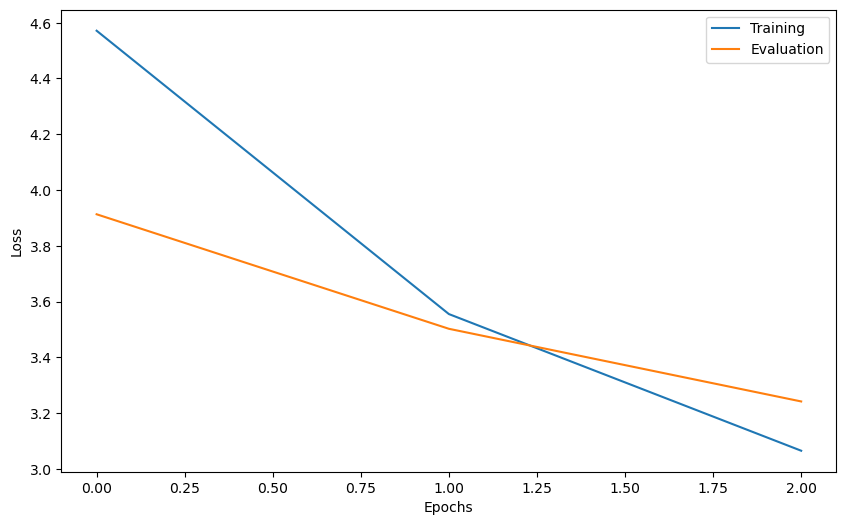

In [301]:
import matplotlib.pyplot as plt
# Plot result
def plot_result(num_epochs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    axs.plot(epochs, train_losses, label="Training")
    axs.plot(epochs, eval_losses, label="Evaluation")
    axs.set_xlabel("Epochs")
    axs.set_ylabel("Loss")
    plt.legend()

plot_result(3, train_losses, valid_losses)

In [26]:
for src_batch, tgt_batch in train_loader:
    src = src_batch
    tgt = tgt_batch
    break
 # Thử in ra một batch và dừng lại

In [27]:
tgt

tensor([[  2,  37, 178,  52,  27,   6, 148,  31, 108,  35, 314, 143,   3,   1,
           1,   1],
        [  2,  15,  23,   5,  30,  28, 435,   3,   1,   1,   1,   1,   1,   1,
           1,   1],
        [  2,   6, 415, 124,  21, 189, 414,   3,   1,   1,   1,   1,   1,   1,
           1,   1],
        [  2,  62,  82, 623,  31, 328, 131, 723, 174,   3,   1,   1,   1,   1,
           1,   1],
        [  2,  71,  69,   7,  29,  10,   4,  34,  19,  73,  35,   6,  11,   3,
           1,   1],
        [  2, 251, 126,   4,   9, 122, 473, 507,  67, 479, 486,   3,   1,   1,
           1,   1],
        [  2,   7,   8,  29, 185, 108,  16,   4,  74,  76,  42,   5,  11,   3,
           1,   1],
        [  2,  53, 655,   9,  56, 561, 391,   3,   1,   1,   1,   1,   1,   1,
           1,   1],
        [  2,   4,   9, 182,   6,   7, 506,  16,   4,   3,   1,   1,   1,   1,
           1,   1],
        [  2,   4, 148,  87,  63,  45,  30,  17,   3,   1,   1,   1,   1,   1,
           1,   1],
        [ 

In [28]:
for i in range(8):
    print(torch.argmax(F.log_softmax(rnn_based_model(src.to(DEVICE), tgt.to(DEVICE)), dim=-1), dim= -1)[i, :])

tensor([  2,   6, 178,  52,  27,   6, 148,  31, 108,  35, 314, 143,   3,   3,
          3,   3], device='cuda:0')
tensor([  2,  15,  23,   5,  30,  10, 435,   3,   3,   3,   3,   3,   3,  17,
         17,  17], device='cuda:0')
tensor([  2,   6, 415, 124,  21, 189, 414,   3,   3,   3,   3,  39,  39,  39,
         10,  10], device='cuda:0')
tensor([  2,  62,  82, 623,  31, 328, 131, 723, 174,   3,   3,   3,   3,   3,
          3,   3], device='cuda:0')
tensor([ 2, 71, 69,  7, 29, 10,  4, 34, 19, 73, 35,  6, 11,  3,  3,  3],
       device='cuda:0')
tensor([  2, 251, 126,   4,   9, 122, 473, 440,  67, 479, 486,   3,   3,   3,
          3, 179], device='cuda:0')
tensor([  2,   7,   8,  29, 185, 108,  16,   4,  74,  76,  42,   5,  11,   3,
          3,   3], device='cuda:0')
tensor([  2,  53, 655,   9,  56, 561, 391,   3,   3,   3,   3,   3,   3,   3,
          3,   3], device='cuda:0')


In [29]:
tgt_vocab.get_itos()[28]

'người'

# Xây dựng chuẩn đánh giá tựa BLEU

In [30]:
import torch
import torch.nn as nn
from collections import Counter

class BLEUInspiredLoss(nn.Module):
    def __init__(self, pad_index, n_gram=4, epsilon=1e-10):
        super(BLEUInspiredLoss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(ignore_index=pad_index, reduction='none')
        self.pad_index = pad_index
        self.n_gram = n_gram
        self.epsilon = epsilon

    def forward(self, outputs, targets):
        """
        outputs: Tensor hình dạng [batch_size, seq_len, vocab_size]
        targets: Tensor hình dạng [batch_size, seq_len]
        """
        batch_size, seq_len, vocab_size = outputs.shape
        
        # Tính CrossEntropy loss
        outputs = outputs.contiguous().view(-1, vocab_size)
        targets = targets.contiguous().view(-1)
        ce_loss = self.criterion(outputs, targets).view(batch_size, -1)
        
        # Lấy dự đoán có xác suất cao nhất
        _, preds = torch.max(outputs.view(batch_size, seq_len, vocab_size), dim=2)
        
        # Tính điểm BLEU cho mỗi cặp dự đoán-target
        bleu_scores = torch.zeros(batch_size, device=outputs.device)
        for i in range(batch_size):
            bleu_scores[i] = self.calculate_bleu_score(preds[i], targets.view(batch_size, -1)[i])
        
        # Kết hợp CrossEntropy loss với điểm BLEU
        combined_loss = ce_loss.mean(dim=1) * (1 - bleu_scores)
        
        return bleu_scores.mean()

    def calculate_bleu_score(self, pred, target):
        preds, targets = [], []
        for i in range(len(pred)):
            if pred[i]!= self.pad_index:
                preds.append(pred[i])
        for i in range(len(target)):
            if target[i]!= self.pad_index:
                targets.append(target[i])
                
        precision_scores = []
        for n in range(1, self.n_gram + 1):
            pred_ngrams = self.get_ngrams(preds, n)
            target_ngrams = self.get_ngrams(targets, n)
            
            matches = sum((pred_ngrams & target_ngrams).values())
            total = sum(pred_ngrams.values()) or 1
            precision_scores.append(matches / total)
        
        geo_mean = torch.exp(torch.tensor(precision_scores).log().mean())
        
        bp = min(1, torch.exp(torch.tensor(1 - len(target) / (len(pred) + self.epsilon))))
        return bp * geo_mean

    @staticmethod
    def get_ngrams(sequence, n):
        return Counter(tuple(sequence[i:i+n]) for i in range(len(sequence) - n + 1))

# Sử dụng hàm loss
pad_index = 0  # Giả sử 0 là chỉ số padding
loss_fn = BLEUInspiredLoss(pad_index)

# Giả lập dữ liệu đầu ra từ mô hình và targets
batch_size, seq_len, vocab_size = 32, 20, 10000
outputs = torch.randn(batch_size, seq_len, vocab_size)
targets = torch.randint(1, vocab_size, (batch_size, seq_len))  # Bắt đầu từ 1 để tránh pad_index

# Tính toán loss
loss = loss_fn(outputs, targets)
print(f"Loss: {loss.item()}")

Loss: 0.0
